In [3]:
import requests
import pandas as pd
import geopandas as gpd

import sys

sys.path.append("../")

# from helper_functions import *
# from loading_data import *
from Code.helper_functions import initial_loading
from Code.algorithms import random_start_hillclimber

POSTGRES password?WelkomCorne!


### Locations per cluster
The first step is to slightly modify the loading of the clusters

In [ ]:
def load_api_data(prnt=False):
    """
    This function loads in information on the current composition of container
    clusters in Amsterdam. It uses the API from data.amsterdam.nl (available at
    'https://api.data.amsterdam.nl/vsd/afvalclusters'). It returns the coordinates,
    amount and volume of different fractions and the address of the clusters. As
    a check, it is determined whether or not the cluster is currently active.
    Returns:
    - df containing coordinates, dict-like amount and volume per fraction and
    address.
    """
    x_coordinates = []
    y_coordinates = []
    aantal = []
    volumes = []
    adresses = []
    buurt = []

    link = 'https://api.data.amsterdam.nl/vsd/afvalclusters'

    while link != None: #This is the case on the last page of the API
        if prnt: # Can be used for some kind of monitoring of progres
            print(link)
        response = requests.get(link)
        output = response.json()
        for result in output['results']:
            if result['cluster_datum_einde_cluster'] == None: #Als het cluster nog actief is
                x_coordinates.append(str(result['cluster_geometrie']['coordinates'][0]))
                y_coordinates.append(str(result['cluster_geometrie']['coordinates'][1]))
                aantal.append(result['cluster_fractie_aantal'])
                volumes.append(result['cluster_fractie_volume'])
                adresses.append(result['bag_adres_openbare_ruimte_naam'])
                buurt.append(result['gbd_buurt_code'])
        try:
            link = output['_links']['next']['href'] #Retrieve link for next page
        except:
            link = None #True for last page of API

    df_clusters = pd.DataFrame([x_coordinates, y_coordinates, aantal, volumes, adresses, buurt]).T
    df_clusters = df_clusters.rename(columns={0: 'cluster_x', 1:'cluster_y', 2:'aantal_per_fractie', 3:'volume_per_fractie', 4: 'street_name', 5:'buurt'})
    # Transform coordinates of clusters to ints, as this helps easing join
    df_clusters['cluster_x'] = df_clusters['cluster_x'].astype('float').round(0).astype('int')
    df_clusters['cluster_y'] = df_clusters['cluster_y'].astype('float').round(0).astype('int')
    df_clusters['wijk'] = df_clusters['buurt'].str[:3]
    df_clusters['stadsdeel'] = df_clusters['buurt'].str[0]
    return df_clusters

In [ ]:
def load_geodata_containers(subsectie=None):
    """
    This function loads in all polygons representing areas in the city of Amsterdam
    where general waste needs to be brought to a container. This is different
    from the alternative where general waste is collected from the sidewalk. This
    is needed to filter the address POI's to relevant POI's for optimization.
    Subsectie is optional parameter to filter on specific stadsdelen. This can be used
    for partial optimization.

    Returns:
    - List of polygons making up the area of centralized garbage collection
    """

    source = gpd.read_file('../data/Inzameling_huisvuil_100220.shp')
    source = source[source['aanbiedwij'] == 'Breng uw restafval  naar een container voor restafval.']
    if subsectie:
        source = source[source['sdcode'] == subsectie]
    return list(source.geometry)

In [ ]:
def get_db_afvalcluster_info():
    """
    Function that modifies loads in data on the garbage clusters from the Postgres
    database and modifies the resulting dataframe in a way that makes it usable
    for future analysis
    Returns:
    - pandas DataFrame containing all information from the database and also the
    added coordinates for the clusters and the type of POI
    """
    polygon_list = load_geodata_containers()
    db_df = get_dataframe("""SELECT *
                             FROM proj_afval_netwerk.afv_rel_nodes_poi
                             """)
    db_df['woning'] = db_df['bk_afv_rel_nodes_poi'].str.split('~')
    db_df['cluster_x'] = db_df['woning'].apply(lambda x: x[0]).astype('float').round(0).astype('int')
    db_df['cluster_y'] = db_df['woning'].apply(lambda x: x[1]).astype('float').round(0).astype('int')
    db_df['type'] = db_df['woning'].apply(lambda x: x[2])
    db_df['bag'] = db_df['woning'].apply(lambda x: x[3])
    print('a')
#     db_df['uses_container'] = db_df.apply(lambda row: address_in_service_area(row['cluster_x'], row['cluster_y'], polygon_list = polygon_list), axis=1)
    db_df = db_df.drop('woning', axis=1)
    return db_df

In [ ]:
def create_all_households(rel_poi_df, subsectie=None):
    """
    Function that creates a dataframe containing all households as rows
    """
    polygon_list = load_geodata_containers(subsectie = subsectie)
    all_households = rel_poi_df[rel_poi_df['type']!='afval_cluster']
    all_households = all_households[['s1_afv_nodes', 'cluster_x', 'cluster_y']]
    print('b')
    all_households['uses_container'] = all_households.apply(lambda row: address_in_service_area(row['cluster_x'], row['cluster_y'], polygon_list=polygon_list), axis=1)
    return all_households

In [ ]:
df_clusters = load_api_data_neigborhood()

In [ ]:
df_clusters['stadsdeel'].value_counts()
# Stadsdeel Zuid-Oost (T) has 423 clusters. This is to be optimized

In [ ]:
rel_poi_df = get_db_afvalcluster_info()

In [ ]:
all_households = create_all_households(rel_poi_df, subsectie='T')

In [ ]:
joined = join_api_db(rel_poi_df, df_clusters)

In [ ]:
joined['rest'], joined['plastic'], joined['papier'], joined['glas'], joined['textiel'], joined['totaal'] = zip(*joined['aantal_per_fractie'].apply(lambda x: containers_per_cluster(x)))

In [ ]:
df_afstandn2 = distance_matrix_with_counts()

In [ ]:
for i in ['T', 'M', 'N', 'A', 'K', 'E', 'F', 'B']:
    print(i)
    all_households, rel_poi_df, joined, df_afstandn2 = initial_loading(use_count=True, subsectie=i)
    joined_cluster_distance, good_result_rich, aansluitingen, avg_distance, penalties = \
    analyze_candidate_solution(joined, all_households, rel_poi_df, df_afstandn2, clean=True, use_count=True)

Do you want to use addresses instead of clusters?True
What stadsdeel do you want to make as a subsection?T
API data loaded
DB relation POIs loaded
Table all households created
API and DB joined
containers per cluster determined


..\Code\loading_data.py:239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verblijfsobjecten['bag'] = verblijfsobjecten['split'].apply(lambda x: x[3]).astype('int64')


distance matrix loaded
How many random iterations?10
How many iterations hillclimber?20
Do you want the results saved(True/False)?True
Do you want to only use a subset of data?Ture
Do you want to use addresses instead of clusters?True
What parameter to optimize on (score/penalties)?penalties
Average distance is : 249.6004611676881
Penalties are: 308.1859662117452
Average distance is : 254.02442956940632
Penalties are: 319.9085892115329
Average distance is : 251.95626616743436
Penalties are: 320.9413878810317
Average distance is : 254.4581740794967
Penalties are: 335.33427856672427
Average distance is : 258.37575446499943
Penalties are: 325.6733294122486
Average distance is : 257.2809305525734
Penalties are: 340.44575707527764
Average distance is : 256.8267005819576
Penalties are: 334.76564096816645
Average distance is : 263.8342913062763
Penalties are: 336.82620506334325
Average distance is : 260.2847936184146
Penalties are: 324.4653209068839
Average distance is : 250.34930114917154
Pe

..\Code\algorithms.py:123: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  today = str(pd.datetime.now().date()) + '-' + str(pd.datetime.now().hour)


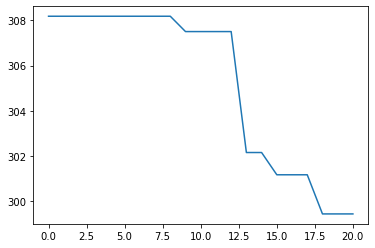

In [4]:
all_households, rel_poi_df, joined, df_afstandn2 = initial_loading()
hill_df, best_solution = random_start_hillclimber(joined, all_households, rel_poi_df, df_afstandn2)

In [ ]:
hill_df, best_solution = random_start_hillclimber(best_solution, all_households, rel_poi_df, df_afstandn2)

How many random iterations?10
How many iterations hillclimber?5000
Do you want the results saved(True/False)?True
Do you want to only use a subset of data?True
Do you want to use addresses instead of clusters?True
What parameter to optimize on (score/penalties)?penalties
Average distance is : 262.65982991480155
Penalties are: 233.10531889616075
Average distance is : 320.6225024782058
Penalties are: 409.69959180377947
Average distance is : 322.06387659201374
Penalties are: 407.30581466452566
Average distance is : 323.35166086855264
Penalties are: 420.21964303157165
Average distance is : 317.8552178998162
Penalties are: 403.97417537540144
Average distance is : 312.7368666186507
Penalties are: 399.76972616875213
Average distance is : 318.27708434137844
Penalties are: 404.8859799062581
Average distance is : 328.9151957667726
Penalties are: 419.0692936965252
Average distance is : 315.1595438338016
Penalties are: 395.23182397681205
Average distance is : 327.5193960176966
Penalties are: 412.3

Average distance is : 262.72165439763137
Penalties are: 227.5681101546542
227.5681101546542 226.9835252407353
Average distance is : 262.92773268691326
Penalties are: 229.4101287673517
229.4101287673517 226.9835252407353
Average distance is : 266.1212491690049
Penalties are: 242.39756257034472
242.39756257034472 226.9835252407353
Average distance is : 263.75956602292246
Penalties are: 233.82738953270248
233.82738953270248 226.9835252407353
Average distance is : 262.4638083081758
Penalties are: 226.53607628496397
226.53607628496397 226.9835252407353
Average distance is : 263.28595524212733
Penalties are: 231.96029917879028
231.96029917879028 226.53607628496397
Average distance is : 262.83103885014526
Penalties are: 233.61040733053835
233.61040733053835 226.53607628496397
Average distance is : 262.4618613573772
Penalties are: 226.57996571345197
226.57996571345197 226.53607628496397
Average distance is : 261.55724970685145
Penalties are: 236.09877135353702
236.09877135353702 226.5360762849

Average distance is : 262.34921383186725
Penalties are: 230.42949760261232
230.42949760261232 213.49797835966694
Average distance is : 261.824239099217
Penalties are: 223.65151238107376
223.65151238107376 213.49797835966694
Average distance is : 262.1156768822364
Penalties are: 210.81836712113488
210.81836712113488 213.49797835966694
Average distance is : 263.25868305463854
Penalties are: 213.92000917431193
213.92000917431193 210.81836712113488
Average distance is : 261.7716364761783
Penalties are: 220.53432560312606
220.53432560312606 210.81836712113488
Average distance is : 262.0660342381356
Penalties are: 212.0712998640843
212.0712998640843 210.81836712113488
Average distance is : 262.7655185007219
Penalties are: 210.63422020472302
210.63422020472302 210.81836712113488
Average distance is : 267.4580355893809
Penalties are: 218.5099860474006
218.5099860474006 210.63422020472302
Average distance is : 262.86978923684194
Penalties are: 213.38835888124362
213.38835888124362 210.634220204

Average distance is : 263.2625483253971
Penalties are: 212.73648891390218
212.73648891390218 208.14839652975408
Average distance is : 262.9465502134858
Penalties are: 210.5970514590324
210.5970514590324 208.14839652975408
Average distance is : 263.1645653668109
Penalties are: 212.8815814816385
212.8815814816385 208.14839652975408
Average distance is : 264.10896173728764
Penalties are: 212.25337384785286
212.25337384785286 208.14839652975408
Average distance is : 259.38986336141784
Penalties are: 222.83432527715246
222.83432527715246 208.14839652975408
Average distance is : 262.2459008769522
Penalties are: 212.74890298602557
212.74890298602557 208.14839652975408
Average distance is : 262.70146220844885
Penalties are: 214.3653152317037
214.3653152317037 208.14839652975408
Average distance is : 263.2817083471557
Penalties are: 208.13665992014612
208.13665992014612 208.14839652975408
Average distance is : 263.519645894612
Penalties are: 210.0419866627023
210.0419866627023 208.1366599201461

Average distance is : 262.413831546628
Penalties are: 206.98740954080114
206.98740954080114 202.50434399558216
Average distance is : 262.24183073879465
Penalties are: 203.63081086365182
203.63081086365182 202.50434399558216
Average distance is : 263.20120798292066
Penalties are: 204.8107891975702
204.8107891975702 202.50434399558216
Average distance is : 262.7358293911654
Penalties are: 207.85330121914959
207.85330121914959 202.50434399558216
Average distance is : 263.4919459876131
Penalties are: 206.14976579159764
206.14976579159764 202.50434399558216
Average distance is : 262.5781881671038
Penalties are: 215.71683887970235
215.71683887970235 202.50434399558216
Average distance is : 262.6619808231565
Penalties are: 203.77011932373307
203.77011932373307 202.50434399558216
Average distance is : 262.53843226707573
Penalties are: 202.05666537105475
202.05666537105475 202.50434399558216
Average distance is : 263.09952987052003
Penalties are: 206.96364079690753
206.96364079690753 202.056665

Average distance is : 265.26973515529255
Penalties are: 208.2912567085598
208.2912567085598 198.25701734091777
Average distance is : 268.668134131438
Penalties are: 199.3290399668888
199.3290399668888 198.25701734091777
Average distance is : 265.05876336761173
Penalties are: 203.07307863904572
203.07307863904572 198.25701734091777
Average distance is : 265.6388299148602
Penalties are: 208.3975112705353
208.3975112705353 198.25701734091777
Average distance is : 266.30599608252714
Penalties are: 205.1672763124363
205.1672763124363 198.25701734091777
Average distance is : 264.0128831641952
Penalties are: 203.7610673897355
203.7610673897355 198.25701734091777
Average distance is : 265.191130020915
Penalties are: 198.22502048223456
198.22502048223456 198.25701734091777
Average distance is : 260.0482530659429
Penalties are: 226.26367579105974
226.26367579105974 198.22502048223456
Average distance is : 263.85899913487043
Penalties are: 206.90742280426198
206.90742280426198 198.22502048223456


Average distance is : 267.36917003056936
Penalties are: 192.99507925016982
192.99507925016982 193.18360585088317
Average distance is : 267.7805008951551
Penalties are: 200.40636368461276
200.40636368461276 192.99507925016982
Average distance is : 267.402528189252
Penalties are: 192.99886376953125
192.99886376953125 192.99507925016982
Average distance is : 266.9241723604875
Penalties are: 198.16519444208558
198.16519444208558 192.99507925016982
Average distance is : 267.52202608751793
Penalties are: 194.9586221127717
194.9586221127717 192.99507925016982
Average distance is : 266.6461582820895
Penalties are: 201.46030602844405
201.46030602844405 192.99507925016982
Average distance is : 267.74324512403797
Penalties are: 196.17357131029212
196.17357131029212 192.99507925016982
Average distance is : 264.9251433759017
Penalties are: 196.60337086022417
196.60337086022417 192.99507925016982
Average distance is : 268.04336674098477
Penalties are: 197.34194314707878
197.34194314707878 192.995079

Average distance is : 265.72606880929686
Penalties are: 191.5074045091712
191.5074045091712 190.10795013162362
Average distance is : 261.9902925717616
Penalties are: 198.53847802734376
198.53847802734376 190.10795013162362
Average distance is : 266.3492115351576
Penalties are: 191.0782634808084
191.0782634808084 190.10795013162362
Average distance is : 266.45262270401423
Penalties are: 193.54545418648095
193.54545418648095 190.10795013162362
Average distance is : 266.1864205376835
Penalties are: 192.35880388077445
192.35880388077445 190.10795013162362
Average distance is : 266.59704447061625
Penalties are: 197.84730005944297
197.84730005944297 190.10795013162362
Average distance is : 267.58298562802725
Penalties are: 198.42883145805027
198.42883145805027 190.10795013162362
Average distance is : 265.8234516380218
Penalties are: 190.23946694548232
190.23946694548232 190.10795013162362
Average distance is : 266.4374715147424
Penalties are: 191.86124830163044
191.86124830163044 190.1079501

Average distance is : 266.0778422112885
Penalties are: 190.47329497961266
190.47329497961266 185.72271866508154
Average distance is : 266.13745598854797
Penalties are: 191.32103305451767
191.32103305451767 185.72271866508154
Average distance is : 267.02041961199126
Penalties are: 206.7200338828974
206.7200338828974 185.72271866508154
Average distance is : 266.3277041950963
Penalties are: 198.04236953290868
198.04236953290868 185.72271866508154
Average distance is : 265.9943527414264
Penalties are: 195.12647412109374
195.12647412109374 185.72271866508154
Average distance is : 267.10589556586547
Penalties are: 187.00090280254778
187.00090280254778 185.72271866508154
Average distance is : 266.3704390060255
Penalties are: 186.62060776154888
186.62060776154888 185.72271866508154
Average distance is : 266.24705824764266
Penalties are: 187.10512472401496
187.10512472401496 185.72271866508154
Average distance is : 265.6176924351071
Penalties are: 192.77805279806384
192.77805279806384 185.72271

Average distance is : 265.6818181036981
Penalties are: 188.4090040123981
188.4090040123981 184.31514799167795
Average distance is : 266.67975784019035
Penalties are: 198.95349450943954
198.95349450943954 184.31514799167795
Average distance is : 265.506586573141
Penalties are: 187.58802127207878
187.58802127207878 184.31514799167795
Average distance is : 264.7549566719959
Penalties are: 189.79030391490807
189.79030391490807 184.31514799167795
Average distance is : 265.3518974445128
Penalties are: 187.36207154381793
187.36207154381793 184.31514799167795
Average distance is : 266.2899170628518
Penalties are: 187.83234931216032
187.83234931216032 184.31514799167795
Average distance is : 265.8687017887231
Penalties are: 185.7299531986246
185.7299531986246 184.31514799167795
Average distance is : 263.71442397561106
Penalties are: 201.15371567170516
201.15371567170516 184.31514799167795
Average distance is : 261.22085419473365
Penalties are: 190.77586072186838
190.77586072186838 184.315147991

Average distance is : 264.51578939512024
Penalties are: 185.7591649753736
185.7591649753736 182.86536149796194
Average distance is : 265.5695503720308
Penalties are: 185.59472694463315
185.59472694463315 182.86536149796194
Average distance is : 264.4423446898554
Penalties are: 201.0152127184827
201.0152127184827 182.86536149796194
Average distance is : 265.0416147491517
Penalties are: 183.88083225792758
183.88083225792758 182.86536149796194
Average distance is : 265.0716568560913
Penalties are: 184.64469304093072
184.64469304093072 182.86536149796194
Average distance is : 265.3204507330711
Penalties are: 185.04222125509511
185.04222125509511 182.86536149796194
Average distance is : 264.8527995385687
Penalties are: 191.59926982846468
191.59926982846468 182.86536149796194
Average distance is : 264.9651075400924
Penalties are: 184.9883234544837
184.9883234544837 182.86536149796194
Average distance is : 265.17522142836594
Penalties are: 190.1347924592391
190.1347924592391 182.8653614979619

Average distance is : 269.3475552805516
Penalties are: 180.0200532651155
180.0200532651155 178.14625711192255
Average distance is : 267.44237724646257
Penalties are: 178.74924740998642
178.74924740998642 178.14625711192255
Average distance is : 267.11514740294166
Penalties are: 177.91668406080166
177.91668406080166 178.14625711192255
Average distance is : 267.472915192656
Penalties are: 181.91592032523778
181.91592032523778 177.91668406080166
Average distance is : 267.23384081940407
Penalties are: 185.06955056895382
185.06955056895382 177.91668406080166
Average distance is : 266.9519902094205
Penalties are: 180.33042703379755
180.33042703379755 177.91668406080166
Average distance is : 267.337683022066
Penalties are: 178.85648155146058
178.85648155146058 177.91668406080166
Average distance is : 267.13701536982467
Penalties are: 181.54395142663043
181.54395142663043 177.91668406080166
Average distance is : 267.23903104550277
Penalties are: 181.2127445652174
181.2127445652174 177.91668406

Average distance is : 269.97323167434485
Penalties are: 192.32646615998635
192.32646615998635 177.20899053158968
Average distance is : 266.50099395563626
Penalties are: 180.33167936905573
180.33167936905573 177.20899053158968
Average distance is : 268.3736419415115
Penalties are: 190.95413329371308
190.95413329371308 177.20899053158968
Average distance is : 266.2370051713397
Penalties are: 180.21310442849864
180.21310442849864 177.20899053158968
Average distance is : 267.1001052682083
Penalties are: 179.43747010869566
179.43747010869566 177.20899053158968
Average distance is : 267.0762911987137
Penalties are: 176.77995282778534
176.77995282778534 177.20899053158968
Average distance is : 271.48595251540286
Penalties are: 182.03434434442931
182.03434434442931 176.77995282778534
Average distance is : 267.29302692246586
Penalties are: 178.58140858525817
178.58140858525817 176.77995282778534
Average distance is : 267.0019037670426
Penalties are: 178.09987117866848
178.09987117866848 176.779

Average distance is : 265.9759155227487
Penalties are: 180.01616510275136
180.01616510275136 176.05300428838314
Average distance is : 267.75537165126804
Penalties are: 179.77298291015623
179.77298291015623 176.05300428838314
Average distance is : 267.1039947264733
Penalties are: 177.18554566491167
177.18554566491167 176.05300428838314
Average distance is : 268.90005711508235
Penalties are: 188.88971724269697
188.88971724269697 176.05300428838314
Average distance is : 263.38922265298476
Penalties are: 186.13804577105978
186.13804577105978 176.05300428838314
Average distance is : 267.15694755238235
Penalties are: 176.00239578379754
176.00239578379754 176.05300428838314
Average distance is : 267.5620230465957
Penalties are: 199.47196545597285
199.47196545597285 176.00239578379754
Average distance is : 267.16711240975746
Penalties are: 176.44012856657608
176.44012856657608 176.00239578379754
Average distance is : 267.2628481607476
Penalties are: 176.8424156334918
176.8424156334918 176.0023

Average distance is : 266.9846735535653
Penalties are: 181.81228585682743
181.81228585682743 175.00055494225543
Average distance is : 267.1042839924191
Penalties are: 176.21643703294836
176.21643703294836 175.00055494225543
Average distance is : 270.61533317248427
Penalties are: 183.44385487432064
183.44385487432064 175.00055494225543
Average distance is : 267.00026792423085
Penalties are: 176.11370592730975
176.11370592730975 175.00055494225543
Average distance is : 267.71804099621335
Penalties are: 175.86444556725542
175.86444556725542 175.00055494225543
Average distance is : 267.13590706145635
Penalties are: 175.55810827105978
175.55810827105978 175.00055494225543
Average distance is : 266.86612926617454
Penalties are: 175.7300004245924
175.7300004245924 175.00055494225543
Average distance is : 267.121162264943
Penalties are: 174.78496798573372
174.78496798573372 175.00055494225543
Average distance is : 268.34158670573174
Penalties are: 190.93043552564535
190.93043552564535 174.7849

Average distance is : 266.9974072467805
Penalties are: 176.31648055366847
176.31648055366847 171.89717790421196
Average distance is : 268.0844545960479
Penalties are: 174.6871769913383
174.6871769913383 171.89717790421196
Average distance is : 268.035303414211
Penalties are: 174.41803957201085
174.41803957201085 171.89717790421196
Average distance is : 267.0259900619438
Penalties are: 179.24436555281926
179.24436555281926 171.89717790421196
Average distance is : 267.2203713635196
Penalties are: 171.55953918987768
171.55953918987768 171.89717790421196
Average distance is : 267.8640912872086
Penalties are: 173.99760814368204
173.99760814368204 171.55953918987768
Average distance is : 263.7215518460155
Penalties are: 183.11754938009508
183.11754938009508 171.55953918987768
Average distance is : 266.0132602235851
Penalties are: 171.370920653789
171.370920653789 171.55953918987768
Average distance is : 265.8564611066603
Penalties are: 173.96973721078328
173.96973721078328 171.370920653789
A

Average distance is : 266.1203229815078
Penalties are: 170.15953256208874
170.15953256208874 169.16448129908727
Average distance is : 260.015575335977
Penalties are: 183.66322613033324
183.66322613033324 169.16448129908727
Average distance is : 266.71219411713116
Penalties are: 172.73659583545592
172.73659583545592 169.16448129908727
Average distance is : 266.0383071294839
Penalties are: 170.4565805349183
170.4565805349183 169.16448129908727
Average distance is : 272.3330434483678
Penalties are: 178.1277864996816
178.1277864996816 169.16448129908727
Average distance is : 266.6039273237678
Penalties are: 175.7357773721078
175.7357773721078 169.16448129908727
Average distance is : 265.4593420361579
Penalties are: 169.33002774357885
169.33002774357885 169.16448129908727
Average distance is : 265.88988908712724
Penalties are: 172.49230645298238
172.49230645298238 169.16448129908727
Average distance is : 265.8950778829656
Penalties are: 169.16762992995118
169.16762992995118 169.164481299087

Average distance is : 263.2101214241323
Penalties are: 178.0676548928041
178.0676548928041 165.9872279346211
Average distance is : 262.8315259533899
Penalties are: 175.83386529399274
175.83386529399274 165.9872279346211
Average distance is : 263.07501449704677
Penalties are: 167.86787548291232
167.86787548291232 165.9872279346211
Average distance is : 263.1609326381498
Penalties are: 167.9176437274464
167.9176437274464 165.9872279346211
Average distance is : 262.2482681868553
Penalties are: 173.00759974527702
173.00759974527702 165.9872279346211
Average distance is : 262.8766093943644
Penalties are: 170.04534268732752
170.04534268732752 165.9872279346211
Average distance is : 262.82205625642735
Penalties are: 165.9872279346211
165.9872279346211 165.9872279346211
Average distance is : 262.9468098657179
Penalties are: 167.63663288049247
167.63663288049247 165.9872279346211
Average distance is : 263.07970279220393
Penalties are: 168.3938342390151
168.3938342390151 165.9872279346211
Averag

Average distance is : 264.5303617769836
Penalties are: 180.01821855232433
180.01821855232433 164.71137879431117
Average distance is : 264.9646060792379
Penalties are: 168.522066249204
168.522066249204 164.71137879431117
Average distance is : 261.90540731128397
Penalties are: 170.3029825514753
170.3029825514753 164.71137879431117
Average distance is : 267.16415777533837
Penalties are: 174.3569728932286
174.3569728932286 164.71137879431117
Average distance is : 263.55534971946093
Penalties are: 173.02957643812354
173.02957643812354 164.71137879431117
Average distance is : 263.0799173061946
Penalties are: 172.07253631925283
172.07253631925283 164.71137879431117
Average distance is : 264.80032374832325
Penalties are: 169.95594875822542
169.95594875822542 164.71137879431117
Average distance is : 264.41727301362084
Penalties are: 175.83722095096581
175.83722095096581 164.71137879431117
Average distance is : 263.4060699041611
Penalties are: 168.1975562513267
168.1975562513267 164.711378794311

Average distance is : 262.3252267198727
Penalties are: 176.38893394183822
176.38893394183822 161.34420271704522
Average distance is : 262.37290239114367
Penalties are: 159.5606908087455
159.5606908087455 161.34420271704522
Average distance is : 261.81177632559564
Penalties are: 166.47425707917637
166.47425707917637 159.5606908087455
Average distance is : 262.29448526607143
Penalties are: 165.19733948206326
165.19733948206326 159.5606908087455
Average distance is : 262.3929363516868
Penalties are: 160.2498252175759
160.2498252175759 159.5606908087455
Average distance is : 261.41784707541325
Penalties are: 164.98526542135428
164.98526542135428 159.5606908087455
Average distance is : 263.29153761607245
Penalties are: 162.62119263426027
162.62119263426027 159.5606908087455
Average distance is : 261.8883084632499
Penalties are: 160.8865034812142
160.8865034812142 159.5606908087455
Average distance is : 263.5417644182801
Penalties are: 166.09751056876058
166.09751056876058 159.5606908087455


Average distance is : 261.45664120883407
Penalties are: 165.9789371683294
165.9789371683294 157.83040711101677
Average distance is : 262.2126507599317
Penalties are: 162.63040180428783
162.63040180428783 157.83040711101677
Average distance is : 263.1275570412712
Penalties are: 158.93164992570578
158.93164992570578 157.83040711101677
Average distance is : 262.4450708671867
Penalties are: 157.83889819571218
157.83889819571218 157.83040711101677
Average distance is : 262.25008838002725
Penalties are: 159.78967251114415
159.78967251114415 157.83040711101677
Average distance is : 262.9612774315526
Penalties are: 163.7484708766716
163.7484708766716 157.83040711101677
Average distance is : 261.8789892259136
Penalties are: 165.2073654425812
165.2073654425812 157.83040711101677
Average distance is : 262.5479535001946
Penalties are: 160.31387321163234
160.31387321163234 157.83040711101677
Average distance is : 263.51940323133675
Penalties are: 167.27641999915096
167.27641999915096 157.8304071110

Average distance is : 260.74586143193994
Penalties are: 169.93473455420678
169.93473455420678 157.34228889832306
Average distance is : 261.4147418465984
Penalties are: 174.69879063893012
174.69879063893012 157.34228889832306
Average distance is : 262.0611301142095
Penalties are: 173.9627469467717
173.9627469467717 157.34228889832306
Average distance is : 260.9020828437533
Penalties are: 157.27540356612184
157.27540356612184 157.34228889832306
Average distance is : 260.4537818078147
Penalties are: 160.29321840373592
160.29321840373592 157.27540356612184
Average distance is : 259.79417317033824
Penalties are: 168.58063026958183
168.58063026958183 157.27540356612184
Average distance is : 261.1377756456794
Penalties are: 160.1525128635109
160.1525128635109 157.27540356612184
Average distance is : 259.1646208308985
Penalties are: 161.32437911271495
161.32437911271495 157.27540356612184
Average distance is : 262.7124382113402
Penalties are: 161.12618463171302
161.12618463171302 157.275403566

Average distance is : 260.7759499967932
Penalties are: 164.2153281893441
164.2153281893441 155.78423029080872
Average distance is : 261.2312022096119
Penalties are: 158.79634241137762
158.79634241137762 155.78423029080872
Average distance is : 266.4984565870024
Penalties are: 160.05835344937378
160.05835344937378 155.78423029080872
Average distance is : 261.95955668221205
Penalties are: 158.1598784334536
158.1598784334536 155.78423029080872
Average distance is : 260.6200179653823
Penalties are: 170.20319078751857
170.20319078751857 155.78423029080872
Average distance is : 260.0158992128387
Penalties are: 158.98408244534068
158.98408244534068 155.78423029080872
Average distance is : 260.4861588194223
Penalties are: 161.40137985993212
161.40137985993212 155.78423029080872
Average distance is : 260.5373393025899
Penalties are: 155.09481558055612
155.09481558055612 155.78423029080872
Average distance is : 261.2835468656182
Penalties are: 164.88608038632984
164.88608038632984 155.0948155805

Average distance is : 261.644050767312
Penalties are: 157.83101575170892
157.83101575170892 154.1650211862608
Average distance is : 261.5563431169092
Penalties are: 163.43493593172843
163.43493593172843 154.1650211862608
Average distance is : 261.59066164770275
Penalties are: 154.17223742198445
154.17223742198445 154.1650211862608
Average distance is : 261.8196480187324
Penalties are: 161.8829786651382
161.8829786651382 154.1650211862608
Average distance is : 259.93192869331057
Penalties are: 157.08906151299036
157.08906151299036 154.1650211862608
Average distance is : 261.2599846542193
Penalties are: 161.03118912665053
161.03118912665053 154.1650211862608
Average distance is : 262.3283163536638
Penalties are: 166.68914416422535
166.68914416422535 154.1650211862608
Average distance is : 261.90858745610313
Penalties are: 163.76610737485672
163.76610737485672 154.1650211862608
Average distance is : 262.3435970431204
Penalties are: 164.88463238228678
164.88463238228678 154.1650211862608
A

Average distance is : 267.67671458891704
Penalties are: 157.27705780579967
157.27705780579967 153.22068551776843
Average distance is : 261.87978351698086
Penalties are: 159.2436835010402
159.2436835010402 153.22068551776843
Average distance is : 263.05852958307173
Penalties are: 158.1916214919543
158.1916214919543 153.22068551776843
Average distance is : 261.39968005258237
Penalties are: 159.77904761804203
159.77904761804203 153.22068551776843
Average distance is : 262.3791243041457
Penalties are: 155.11527875429883
155.11527875429883 153.22068551776843
Average distance is : 261.43821677476296
Penalties are: 155.97070538784868
155.97070538784868 153.22068551776843
Average distance is : 262.04062861492844
Penalties are: 155.23179070606716
155.23179070606716 153.22068551776843
Average distance is : 261.47355372880554
Penalties are: 152.62296822060884
152.62296822060884 153.22068551776843
Average distance is : 261.51578417694157
Penalties are: 153.22224663524815
153.22224663524815 152.622

Average distance is : 261.42977779287924
Penalties are: 162.38866276058252
162.38866276058252 152.62296822060884
Average distance is : 262.00840319219253
Penalties are: 154.11892217551903
154.11892217551903 152.62296822060884
Average distance is : 261.48963112950685
Penalties are: 160.83291576444614
160.83291576444614 152.62296822060884
Average distance is : 261.0207192556466
Penalties are: 157.23754827410517
157.23754827410517 152.62296822060884
Average distance is : 262.5366709678935
Penalties are: 156.6254986838195
156.6254986838195 152.62296822060884
Average distance is : 261.4381621647216
Penalties are: 154.41476750307817
154.41476750307817 152.62296822060884
Average distance is : 261.91091526887635
Penalties are: 154.21108510593132
154.21108510593132 152.62296822060884
Average distance is : 261.5614020183451
Penalties are: 153.4039823164777
153.4039823164777 152.62296822060884
Average distance is : 261.59950406267245
Penalties are: 156.3316690442831
156.3316690442831 152.62296822

Average distance is : 261.3814167965353
Penalties are: 155.5320740245404
155.5320740245404 152.31645236275634
Average distance is : 262.3464167084839
Penalties are: 153.41702377616437
153.41702377616437 152.31645236275634
Average distance is : 261.7860000632418
Penalties are: 156.9203687216066
156.9203687216066 152.31645236275634
Average distance is : 264.25424454316453
Penalties are: 170.22091836561333
170.22091836561333 152.31645236275634
Average distance is : 261.43251512926776
Penalties are: 155.3956856026833
155.3956856026833 152.31645236275634
Average distance is : 261.079268029887
Penalties are: 152.91121710610113
152.91121710610113 152.31645236275634
Average distance is : 261.390694083143
Penalties are: 161.63429081221076
161.63429081221076 152.31645236275634
Average distance is : 262.26979724054115
Penalties are: 156.03120509064664
156.03120509064664 152.31645236275634
Average distance is : 261.72718593314346
Penalties are: 159.14902768224854
159.14902768224854 152.31645236275

Average distance is : 260.6810476679899
Penalties are: 148.4849036003906
148.4849036003906 148.26034103935805
Average distance is : 261.3522041405815
Penalties are: 154.56375650660215
154.56375650660215 148.26034103935805
Average distance is : 260.8935020078102
Penalties are: 150.08304706406827
150.08304706406827 148.26034103935805
Average distance is : 259.348120057781
Penalties are: 150.63093760879718
150.63093760879718 148.26034103935805
Average distance is : 260.58181344490924
Penalties are: 150.8721716341867
150.8721716341867 148.26034103935805
Average distance is : 260.96613344605225
Penalties are: 154.5091075871439
154.5091075871439 148.26034103935805
Average distance is : 260.4555416071293
Penalties are: 172.38977181637878
172.38977181637878 148.26034103935805
Average distance is : 260.69384560154185
Penalties are: 151.20487061096253
151.20487061096253 148.26034103935805
Average distance is : 260.51186970756163
Penalties are: 150.43513541799345
150.43513541799345 148.2603410393

Average distance is : 261.76190381364876
Penalties are: 146.60915511824396
146.60915511824396 145.92510278945355
Average distance is : 261.9754175744952
Penalties are: 145.76854366747335
145.76854366747335 145.92510278945355
Average distance is : 262.0183000049057
Penalties are: 151.42669341485163
151.42669341485163 145.76854366747335
Average distance is : 264.1145121113139
Penalties are: 171.83105169192882
171.83105169192882 145.76854366747335
Average distance is : 260.8378391850754
Penalties are: 159.47804750987135
159.47804750987135 145.76854366747335
Average distance is : 262.0557811307802
Penalties are: 151.58303908207023
151.58303908207023 145.76854366747335
Average distance is : 262.3157421767881
Penalties are: 146.2487044962425
146.2487044962425 145.76854366747335
Average distance is : 258.31581819809185
Penalties are: 152.24078212966504
152.24078212966504 145.76854366747335
Average distance is : 263.8644392378232
Penalties are: 151.8498015963996
151.8498015963996 145.768543667

Average distance is : 263.3572383141702
Penalties are: 146.65401659944808
146.65401659944808 144.08942438972616
Average distance is : 261.8768451761128
Penalties are: 150.03748176607937
150.03748176607937 144.08942438972616
Average distance is : 262.15600424692707
Penalties are: 148.2431831670558
148.2431831670558 144.08942438972616
Average distance is : 261.833362026798
Penalties are: 144.05139176395667
144.05139176395667 144.08942438972616
Average distance is : 268.06748076243974
Penalties are: 153.0216591381872
153.0216591381872 144.05139176395667
Average distance is : 261.59934430662395
Penalties are: 145.4532519422628
145.4532519422628 144.05139176395667
Average distance is : 261.833362026798
Penalties are: 144.73914383358095
144.73914383358095 144.05139176395667
Average distance is : 261.58287184809416
Penalties are: 149.3620813203142
149.3620813203142 144.05139176395667
Average distance is : 261.2635500917138
Penalties are: 145.7757490341753
145.7757490341753 144.05139176395667
